# «Стальная птица»: уменьшение потребления электроэнергии

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Наша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:

- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

**Файл `Файл data_arc_new.csv`**
- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.

**Файл `Файл data_bulk_new.csv`**
- key — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала.

**Файл `data_bulk_time_new.csv`**
- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.

**Файл `data_gas_new.csv`**
- key — номер партии;
- Газ 1 — объём подаваемого газа.

**Файл `data_temp_new.csv`**
- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.

**Файл `data_wire_new.csv`**
- key — номер партии;
- Wire 1 … Wire 15 — объём подаваемых проволочных материалов.

**Файл `data_wire_time_new.csv`**
- key — номер партии;
- Wire 1 … Wire 15 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Подготовка

### Загрузка библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import phik


RANDOM_STATE = 40324
TEST_SIZE = 0.25

datasets_directory = 'https://code.s3.yandex.net/datasets/'

## Вспомогательные функции

In [3]:
def transform_columns_values(df):
    '''
    Функция приводит значения колонок и значений к единому формату
    Заменяет пробелы на _, приводит к нижнему регистру
    Проверяет явные дубли и пропущенные значения
    '''
    df.columns = df.columns.str.replace(' ', '_', regex=True).str.lower()
    object_columns = df.select_dtypes('object').columns
    df[object_columns] = df.select_dtypes('object').apply(
        lambda x: x.str.replace(' ', '_', regex=True).str.lower()
    )
    # Обработка дублей
    print(f'''Явных дублей: {df.duplicated().sum()}\n\n''')

    # Обработка пропущенных значений
    print('Пропущенных значений:\n')
    display(
        (
            pd.DataFrame(
                round(df.isna().mean() * 100, 1).sort_values(ascending=False)
            ).style.background_gradient('coolwarm')
        )
    )
    print('INFO')
    display(df.info())
    print('\n')
    print('DESCRIBE')
    display(df.describe())
    print('\n')
    print('HEAD')
    display(df.head())

    return df

In [4]:
def plot_numeric(df, variable, title, xlabel, bins):
    '''Рисует графики распределения количественных переменных'''
    f, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(20, 7), gridspec_kw={'height_ratios': [4, 1]}
    )
    f.suptitle(title, fontsize=20)

    ax1.hist(df[variable], bins=bins)
    ax1.set_ylabel('Количество измерений')

    ax2.boxplot(df[variable], vert=False)
    ax2.set_xlabel(xlabel)
    ax2.set_xticks([])
    ax2.set_yticks([])

    plt.show()

### Загрузка данных

In [5]:
# Нагрев дугой
arc = pd.read_csv(
    datasets_directory + 'data_arc_new.csv',
    parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'],
)

# Подача сыпучих материалов
bulk = pd.read_csv(datasets_directory + 'data_bulk_new.csv')

# Время подачи сыпучих материалов
bulk_time = pd.read_csv(
    datasets_directory + 'data_bulk_time_new.csv',
    parse_dates=[f'Bulk {x}' for x in range(1, 16)],
)

# Данные о продувке сплава газом
gas = pd.read_csv(datasets_directory + 'data_gas_new.csv')

# Результаты измерения температуры
temperature = pd.read_csv(
    datasets_directory + 'data_temp_new.csv', parse_dates=['Время замера']
)

# Данные о проволочных материалах (объём);
wire = pd.read_csv(datasets_directory + 'data_wire_new.csv')

# Данные о проволочных материалах (время);
wire_time = pd.read_csv(
    datasets_directory + 'data_wire_time_new.csv',
    parse_dates=[f'Wire {x}' for x in range(1, 10)],
)

## Исследовательский анализ данных

### Нагрев дугой

In [6]:
arc = transform_columns_values(arc)

Явных дублей: 0


Пропущенных значений:



,0
key,0.000000
начало_нагрева_дугой,0.000000
конец_нагрева_дугой,0.000000
активная_мощность,0.000000
реактивная_мощность,0.000000


INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None



DESCRIBE


,key,активная_мощность,реактивная_мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284




HEAD


,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [7]:
# Колонки стоит перевести в латиницу
arc.columns = [
    'key',
    'arc_start',
    'arc_finish',
    'active_power',
    'reactive_power',
]

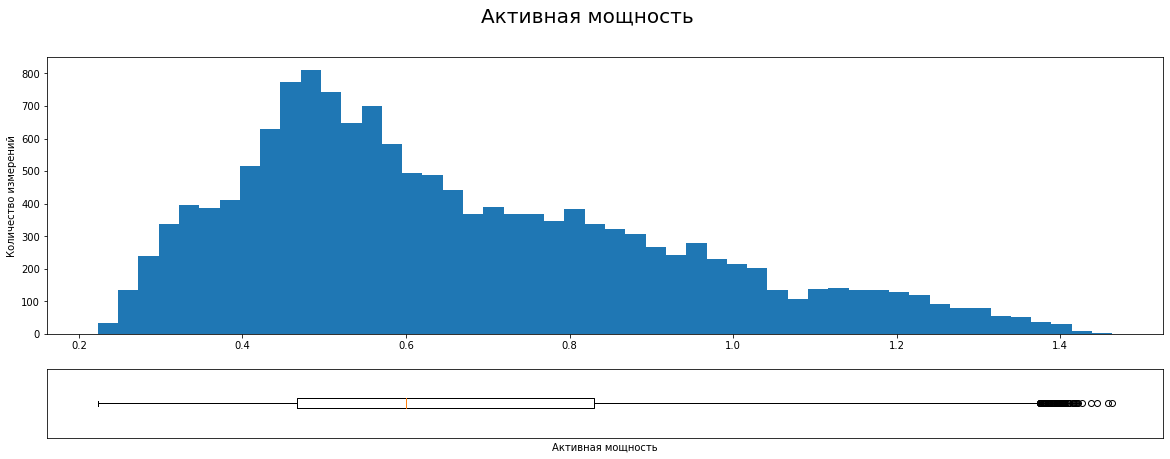

In [8]:
plot_numeric(arc, 'active_power', 'Активная мощность', 'Активная мощность', 50)

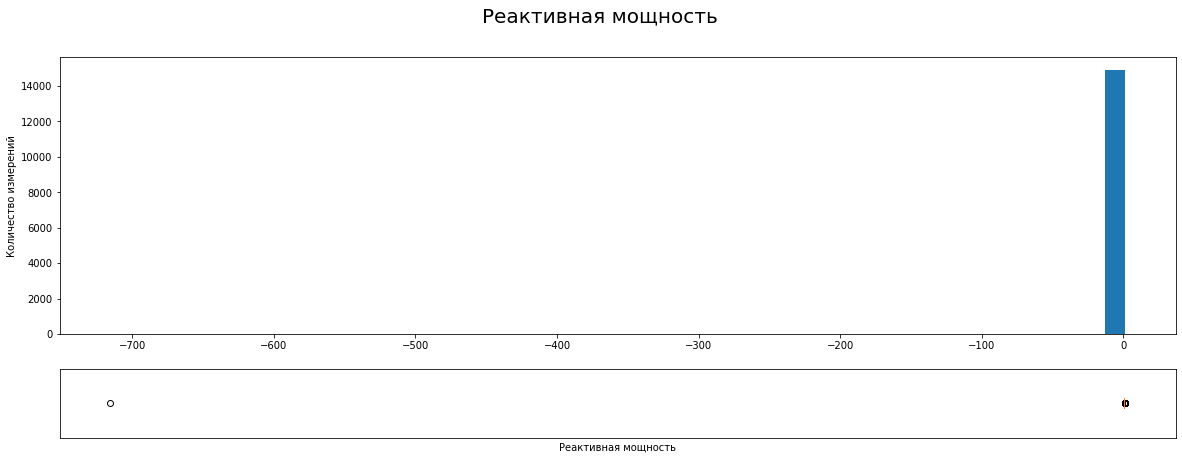

In [9]:
plot_numeric(
    arc, 'reactive_power', 'Реактивная мощность', 'Реактивная мощность', 50
)

Тут явная ошибка с огромной отрицательной мощностью. От неё стоит избавиться. Причем лучше сделать это во всех датафреймах.

In [10]:
# Партия
key_to_drop = arc[arc['reactive_power'] < 0]['key'].iloc[0]
# Убираем из всех датафреймов
arc = arc[arc['key'] != key_to_drop]
bulk = bulk[bulk['key'] != key_to_drop]
bulk_time = bulk_time[bulk_time['key'] != key_to_drop]
gas = gas[gas['key'] != key_to_drop]
temperature = temperature[temperature['key'] != key_to_drop]
wire = wire[wire['key'] != key_to_drop]
wire_time = wire_time[wire_time['key'] != key_to_drop]

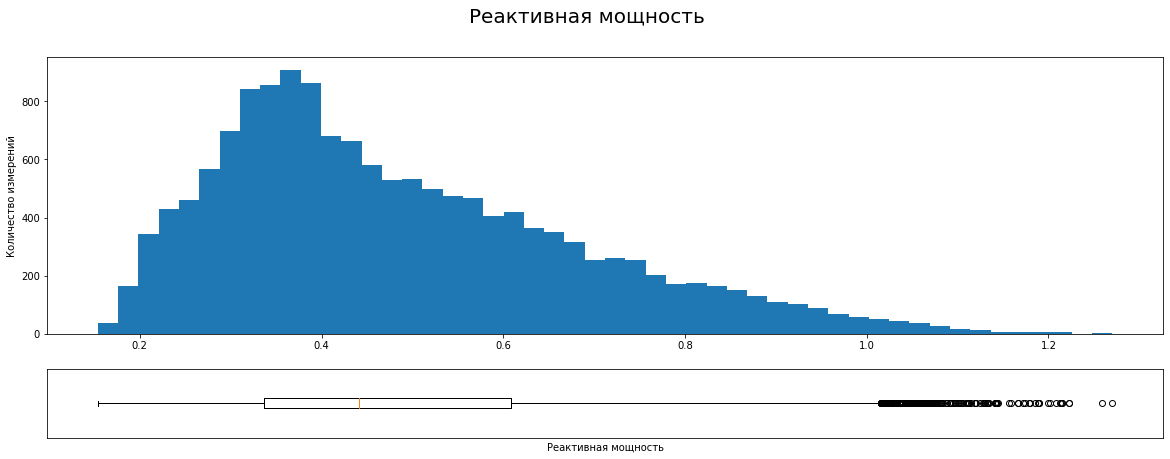

In [11]:
plot_numeric(
    arc, 'reactive_power', 'Реактивная мощность', 'Реактивная мощность', 50
)

### Подача сыпучих материалов

In [12]:
bulk = transform_columns_values(bulk)

Явных дублей: 0


Пропущенных значений:



,0
bulk_8,100.000000
bulk_9,99.400000
bulk_13,99.400000
bulk_2,99.300000
bulk_7,99.200000
bulk_5,97.500000
bulk_10,94.400000
bulk_11,94.300000
bulk_1,91.900000
bulk_6,81.600000


INFO
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3128 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   575 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2805 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 415.4 KB


None



DESCRIBE


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3128.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,575.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2805.000000,2248.000000
mean,1624.226343,39.242063,253.045455,113.879045,104.394477,107.025974,118.893913,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.274866,160.513345
std,933.445456,18.277654,21.180578,75.483494,48.184126,81.790646,72.116564,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.878317,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,815.750000,27.000000,242.000000,58.000000,72.000000,70.000000,69.500000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1621.500000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.250000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,206.000000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000




HEAD


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Если материал не подавался, значит его было 0. Справедливо будет заполнить пропущенные значения нулями.

In [13]:
bulk = bulk.fillna(0)

bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


### Время подачи сыпучих материалов

In [14]:
bulk_time = transform_columns_values(bulk_time)

Явных дублей: 0


Пропущенных значений:



,0
bulk_8,100.000000
bulk_9,99.400000
bulk_13,99.400000
bulk_2,99.300000
bulk_7,99.200000
bulk_5,97.500000
bulk_10,94.400000
bulk_11,94.300000
bulk_1,91.900000
bulk_6,81.600000


INFO
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3128 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   575 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2805 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 415.4 KB


None



DESCRIBE


,key
count,3128.000000
mean,1624.226343
std,933.445456
min,1.000000
25%,815.750000
50%,1621.500000
75%,2431.250000
max,3241.000000




HEAD


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


Промущенные значения времени не будем заполнять. Эти ячейки нам вообще не понадобятся.

### Данные о продувке сплава газом

In [15]:
gas = transform_columns_values(gas)

Явных дублей: 0


Пропущенных значений:



,0
key,0.000000
газ_1,0.000000


INFO
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3238 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3238 non-null   int64  
 1   газ_1   3238 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.9 KB


None



DESCRIBE


,key,газ_1
count,3238.000000,3238.000000
mean,1621.708771,11.001883
std,935.490478,6.221280
min,1.000000,0.008399
25%,812.250000,7.042678
50%,1621.500000,9.832531
75%,2431.750000,13.770937
max,3241.000000,77.995040




HEAD


,key,газ_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [16]:
gas = gas.rename(columns={'газ_1': 'gas_1'})

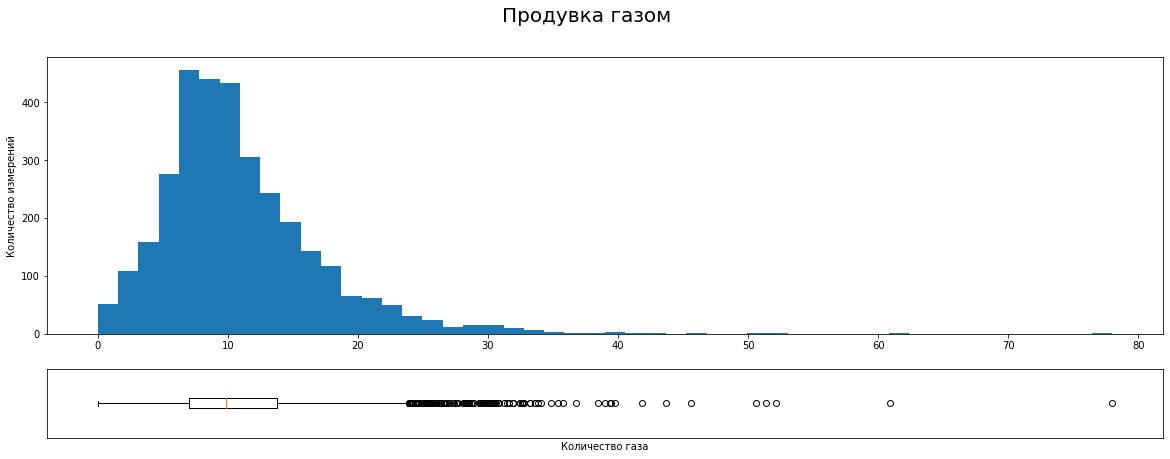

In [17]:
plot_numeric(gas, 'gas_1', 'Продувка газом', 'Количество газа', bins=50)

Данные содержат много выбросов. К тому же не указано время продувки. Возможно, этот датасет окажется для нас бесполезным.

In [18]:
temperature = transform_columns_values(temperature)

Явных дублей: 0


Пропущенных значений:



,0
температура,18.900000
key,0.000000
время_замера,0.000000


INFO
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18087 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18087 non-null  int64         
 1   время_замера  18087 non-null  datetime64[ns]
 2   температура   14660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 565.2 KB


None



DESCRIBE


,key,температура
count,18087.000000,14660.000000
mean,1616.322884,1590.727490
std,934.733659,20.396206
min,1.000000,1191.000000
25%,807.000000,1580.000000
50%,1617.000000,1590.000000
75%,2429.500000,1599.000000
max,3241.000000,1705.000000




HEAD


,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Пропущенные замеры температуры нам точно не нужны, ведь именно их мы будем предсказывать.

In [19]:
temperature = temperature.dropna()

In [20]:
temperature.columns = ['key', 'time', 'temperature']

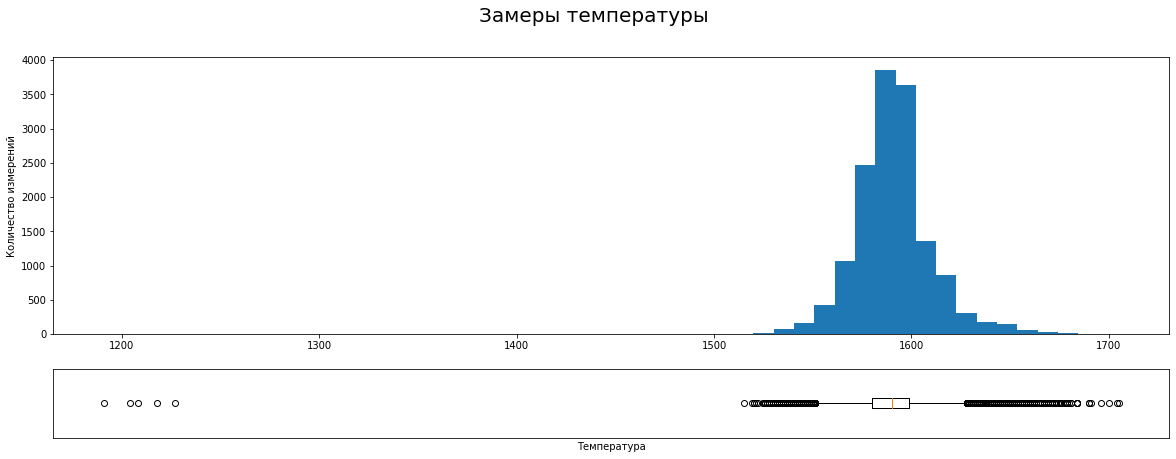

In [21]:
plot_numeric(
    temperature, 'temperature', 'Замеры температуры', 'Температура', bins=50
)

Температура плавления стали 1450 градусов. Соответственно, если температура упала ниже, значит, партия испорчена. Нужно найти все такие случаи во всех датафреймах и удалить.

In [22]:
# Партии к удалению
keys_to_drop = temperature[temperature['temperature'] <= 1450]['key'].tolist()

# Убираем из всех датафреймов
arc = arc[~arc['key'].isin(keys_to_drop)]
bulk = bulk[~bulk['key'].isin(keys_to_drop)]
bulk_time = bulk_time[~bulk_time['key'].isin(keys_to_drop)]
gas = gas[~gas['key'].isin(keys_to_drop)]
temperature = temperature[~temperature['key'].isin(keys_to_drop)]
wire = wire[~wire['key'].isin(keys_to_drop)]
wire_time = wire_time[~wire_time['key'].isin(keys_to_drop)]

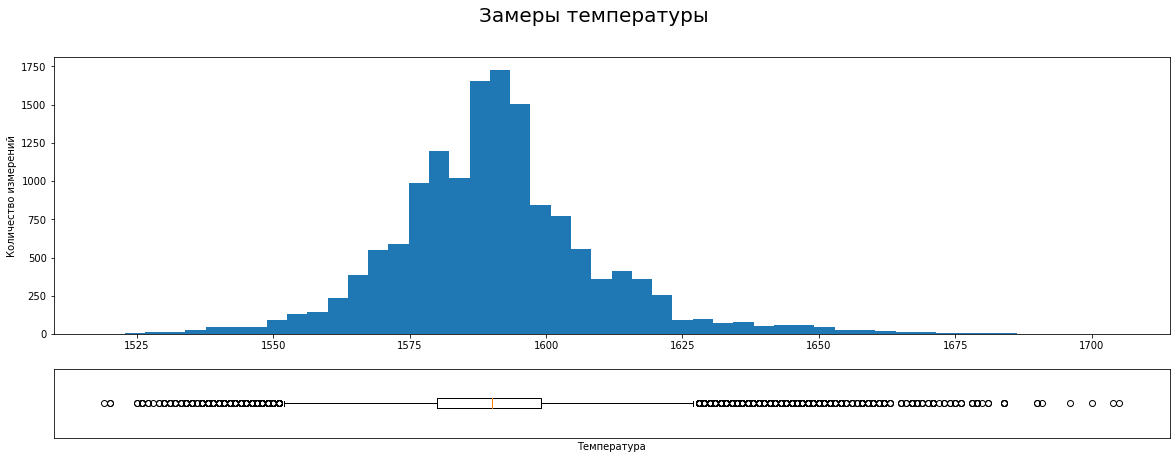

In [23]:
plot_numeric(
    temperature, 'temperature', 'Замеры температуры', 'Температура', bins=50
)

### Данные о проволочных материалах

In [24]:
wire = transform_columns_values(wire)

Явных дублей: 0


Пропущенных значений:



,0
wire_5,100.000000
wire_7,99.600000
wire_4,99.500000
wire_8,99.400000
wire_9,99.100000
wire_3,98.000000
wire_6,97.600000
wire_2,65.000000
wire_1,0.800000
key,0.000000


INFO
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3075 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3075 non-null   int64  
 1   wire_1  3049 non-null   float64
 2   wire_2  1077 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 264.3 KB


None



DESCRIBE


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3075.000000,3049.000000,1077.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.202602,100.857538,50.596728,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,933.550524,42.001374,39.353556,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,821.500000,72.115684,20.180161,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1618.000000,100.152000,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.500000,126.060479,70.242637,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604




HEAD


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Если материал не подавался, значит его было 0. Справедливо будет заполнить пропущенные значения нулями.

In [25]:
wire = wire.fillna(0)
wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
wire_time = transform_columns_values(wire_time)

Явных дублей: 0


Пропущенных значений:



,0
wire_5,100.000000
wire_7,99.600000
wire_4,99.500000
wire_8,99.400000
wire_9,99.100000
wire_3,98.000000
wire_6,97.600000
wire_2,65.000000
wire_1,0.800000
key,0.000000


INFO
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3075 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3075 non-null   int64         
 1   wire_1  3049 non-null   datetime64[ns]
 2   wire_2  1077 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 264.3 KB


None



DESCRIBE


,key
count,3075.000000
mean,1623.202602
std,933.550524
min,1.000000
25%,821.500000
50%,1618.000000
75%,2434.500000
max,3241.000000




HEAD


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


### Адекватность данных

Важно, чтобы каждый случай нашего процесса удовлетворял двум условиям. У него должен быть первый замер, который проводится до применения сыпучих материалов и проволоки, и должен быть последний замер, который проводится после всех циклов легирования. Напишем обработку, которая позволит нам получить идентификаторы таких партий. 

In [27]:
keys_ok = []
keys_not_ok = []

for key in temperature['key'].unique():
    # Листы с метками операционного времени
    min_operations = []
    max_operations = []

    # Замеры температур
    min_temperature_time = temperature[temperature['key'] == key]['time'].min()
    max_temperature_time = temperature[temperature['key'] == key]['time'].max()

    # Вычисляем минимальное время старта
    # и максимальное время финиша нагрева
    arc_min_time = arc[arc['key'] == key]['arc_start'].min()
    arc_max_time = arc[arc['key'] == key]['arc_finish'].min()

    min_operations.append(arc_min_time)
    max_operations.append(arc_max_time)
    # Вычисляем минимальное и максимальное время добавки
    # легирующих материалов

    # Обработка случаев, если сыпучие материалы не добавлялись
    try:
        bulk_min_time = (
            bulk_time[bulk_time['key'] == key]
            .iloc[:, 1:]
            .dropna(axis=1)
            .T.min()
            .iloc[0]
        )

        bulk_max_time = (
            bulk_time[bulk_time['key'] == key]
            .iloc[:, 1:]
            .dropna(axis=1)
            .T.max()
            .iloc[0]
        )

        min_operations.append(bulk_min_time)
        max_operations.append(bulk_max_time)
    except:
        pass

    # Обработка случаев, если проволока не добавлялась
    try:

        wire_min_time = (
            wire_time[wire_time['key'] == key]
            .iloc[:, 1:]
            .dropna(axis=1)
            .T.min()
            .iloc[0]
        )

        wire_max_time = (
            wire_time[wire_time['key'] == key]
            .iloc[:, 1:]
            .dropna(axis=1)
            .T.max()
            .iloc[0]
        )
        min_operations.append(wire_min_time)
        max_operations.append(wire_max_time)
    except:
        pass

    # Вычисляем минимальное и максимальное время каких-либо операций
    min_operation_time = min(min_operations)
    max_operation_time = min(max_operations)

    # Проверяем, соответствует ли партия условиям
    if (min_temperature_time < min_operation_time) & (
        max_temperature_time > max_operation_time
    ):
        keys_ok.append(key)
    else:
        keys_not_ok.append(key)

In [28]:
not_ok_share = round(
    (len(keys_not_ok) / (len(keys_not_ok) + len(keys_ok))) * 100, 1
)
not_ok_share

23.1

23.1% данных нам не подходит. Посмотрим на одну из таких партий.

In [29]:
example_not_ok = keys_not_ok[6]

temperature[temperature['key'] == example_not_ok]

,key,time,temperature
13948,2504,2019-08-10 17:31:43,1583.0


Партия с единственным замером температуры.

Исключим неподходящие `key` из наших данных

In [30]:
# Убираем из всех датафреймов
arc = arc[arc['key'].isin(keys_ok)]
bulk = bulk[bulk['key'].isin(keys_ok)]
bulk_time = bulk_time[bulk_time['key'].isin(keys_ok)]
gas = gas[gas['key'].isin(keys_ok)]
temperature = temperature[temperature['key'].isin(keys_ok)]
wire = wire[wire['key'].isin(keys_ok)]
wire_time = wire_time[wire_time['key'].isin(keys_ok)]

In [31]:
temperature

,key,time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


### Промежуточный вывод

- Загрузили данные;
- Визуально оценили данные;
- Избавились от выбросов;
- Заполнили пропуски;
- Оставили только адекватные данные;

## Feature engineering

### Мощность и работа

У нас есть датасет с мощностью и временем её применения. Складывать активную и реактивную мощность мы не можем. Вычислим полную мощность и работу, потом проведем агрегацию. Неизвестно, какая метрика лучше скажется на модели. 

In [32]:
arc['arc_total_power'] = np.sqrt(
    arc['active_power'] ** 2 + arc['reactive_power'] ** 2
)

arc['arc_duration_seconds'] = (
    arc['arc_finish'] - arc['arc_start']
).dt.total_seconds()

arc['arc_work'] = arc['arc_total_power'] * arc['arc_duration_seconds']

arc.head()

,key,arc_start,arc_finish,active_power,reactive_power,arc_total_power,arc_duration_seconds,arc_work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228.0,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185.0,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172.0,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365.0,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148.0,159.830252


In [33]:
arc_prepared = (
    arc.groupby('key')[['arc_total_power', 'arc_work']].sum().reset_index()
)

arc_prepared.head()

,key,arc_total_power,arc_work
0,1,3.718736,770.282114
1,2,2.588349,481.760005
2,3,5.019223,722.837668
3,4,3.400038,683.455597
4,5,2.816980,512.169934


### Общее количество сыпучих материалов и проволоки

Нельзя исключать, что модель лучше обучится, если будет видеть общее количество материалов.

In [34]:
bulk['bulk_total'] = bulk.sum(axis=1)
wire['wire_total'] = wire.sum(axis=1)

### Определение целевой переменной

Целевой переменной в нашем случае является последний замер температуры. А первый замер может быть одним из признаков. Напишем обрабтку, которая сформирует нам нужный датафрейм из источника `temperature`

In [35]:
total_temp = pd.DataFrame()

for key in temperature['key'].unique():
    # Вычисляем минимальную и максимальную температуры для каждого key
    min_temperature_time = temperature[temperature['key'] == key]['time'].min()
    max_temperature_time = temperature[temperature['key'] == key]['time'].max()

    # Фильтруем датафреймы и переименовываем колонки
    min_temp = temperature[
        (temperature['key'] == key)
        & (temperature['time'] == min_temperature_time)
    ]

    min_temp = min_temp[['key', 'temperature']].rename(
        columns={'temperature': 'temperature_start'}
    )

    max_temp = temperature[
        (temperature['key'] == key)
        & (temperature['time'] == max_temperature_time)
    ]
    max_temp = max_temp[['key', 'temperature']].rename(
        columns={'temperature': 'temperature_finish'}
    )

    # Собираем итоговый датафрейм
    key_temp = min_temp.merge(max_temp)
    total_temp = pd.concat([total_temp, key_temp])

total_temp.reset_index(drop=True).head()

,key,temperature_start,temperature_finish
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


In [36]:
total_temp

,key,temperature_start,temperature_finish
0,1,1571.0,1613.0
0,2,1581.0,1602.0
0,3,1596.0,1599.0
0,4,1601.0,1625.0
0,5,1576.0,1602.0
...,...,...,...
0,2495,1570.0,1591.0
0,2496,1554.0,1591.0
0,2497,1571.0,1589.0
0,2498,1591.0,1594.0


### Промежуточный вывод

- Посчитали мощность и работу;
- Создали общее количество материалов и проволоки;
- Выделили целевую переменную;

## Общий датафрейм

### Объединение данных

Нам нужны партии, которые присутствуют во всех датафреймах. Поэтому объедими их по ключу `key` с помощью *inner join*.

In [37]:
total_df = (
    total_temp.merge(arc_prepared)
    .merge(bulk)
    .merge(wire)
    .merge(gas)
    .set_index('key')
)

total_df['total_materials'] = total_df['bulk_total'] + total_df['wire_total']

In [38]:
total_df

,temperature_start,temperature_finish,arc_total_power,arc_work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_total,gas_1,total_materials
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,3.718736,770.282114,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.059998,29.749986,615.059998
2,1581.0,1602.0,2.588349,481.760005,0.0,0.0,0.0,73.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.052315,12.555561,682.052315
3,1596.0,1599.0,5.019223,722.837668,0.0,0.0,0.0,34.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.160157,28.554793,641.160157
4,1601.0,1625.0,3.400038,683.455597,0.0,0.0,0.0,81.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.063515,18.841219,692.063515
5,1576.0,1602.0,2.816980,512.169934,0.0,0.0,0.0,78.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.352796,5.413692,692.352796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,3.868721,694.177326,0.0,0.0,21.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2584.150879,7.125735,5798.150879
2496,1554.0,1591.0,5.070316,815.818538,0.0,0.0,0.0,63.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2610.179527,9.412616,5902.179527
2497,1571.0,1589.0,4.360918,823.020520,0.0,0.0,0.0,85.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2600.134723,6.271699,5762.134723


### Корреляционный анализ

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable wire_5 for analysis 1. Dropping this column
  warnings.warn(


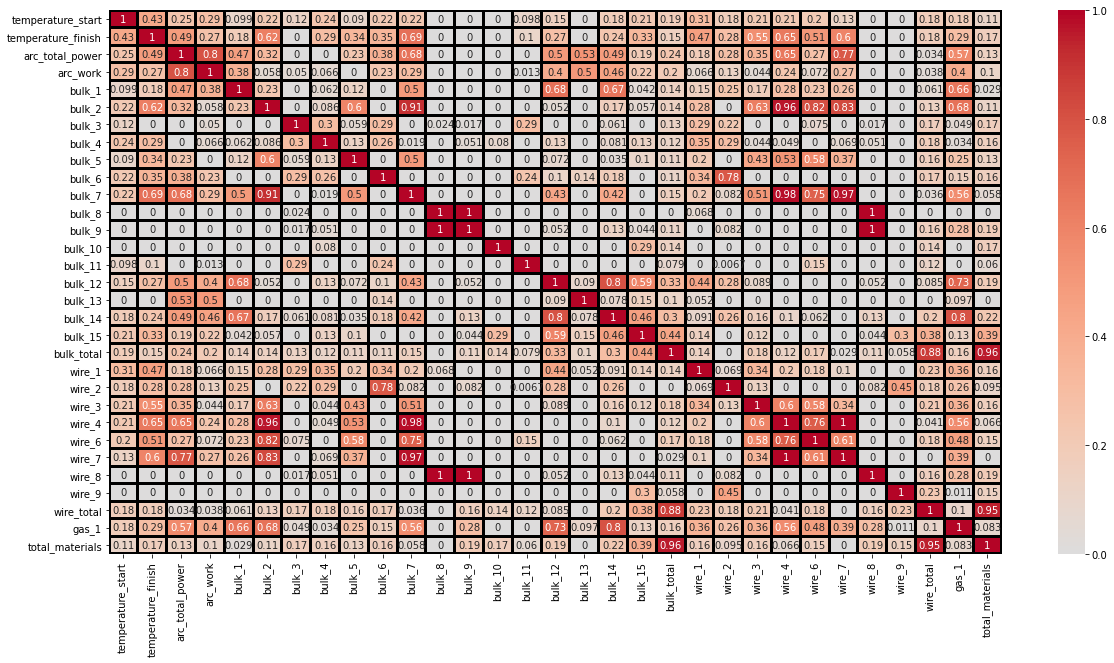

In [39]:
plt.figure(figsize=(20, 10))
sns.heatmap(
    total_df.phik_matrix(interval_cols=total_df.columns),
    cmap='coolwarm',
    center=0,
    annot=True,
    linewidths=2,
    linecolor='black',
)

Обнаружилось довольно много переменных с сильной корреляцией. Часто среди них встречаются переменные с единственным значением. Например `bulk_8`. А также переменные, в которых одинаковое количество значений, например `wire_8` и `bulk_9`. Почистим их. Также интересно, что `полная мощность` лучше коррелирует с целевой переменной, чем `работа`. От `работы` придётся избавиться. Также можно избавиться от признаков, которые вообще никак не объясняют целевую переменную.

In [40]:
total_df = total_df.drop(
    [
        'arc_work',
        'wire_4',
        'bulk_7',
        'wire_total',
        'total_materials',
        'wire_8',
        'bulk_2',
        'bulk_14',
        'wire_5',
        'bulk_3',
        'bulk_8',
        'bulk_9',
        'bulk_10',
        'bulk_13',
        'wire_9',
    ],
    axis=1,
)

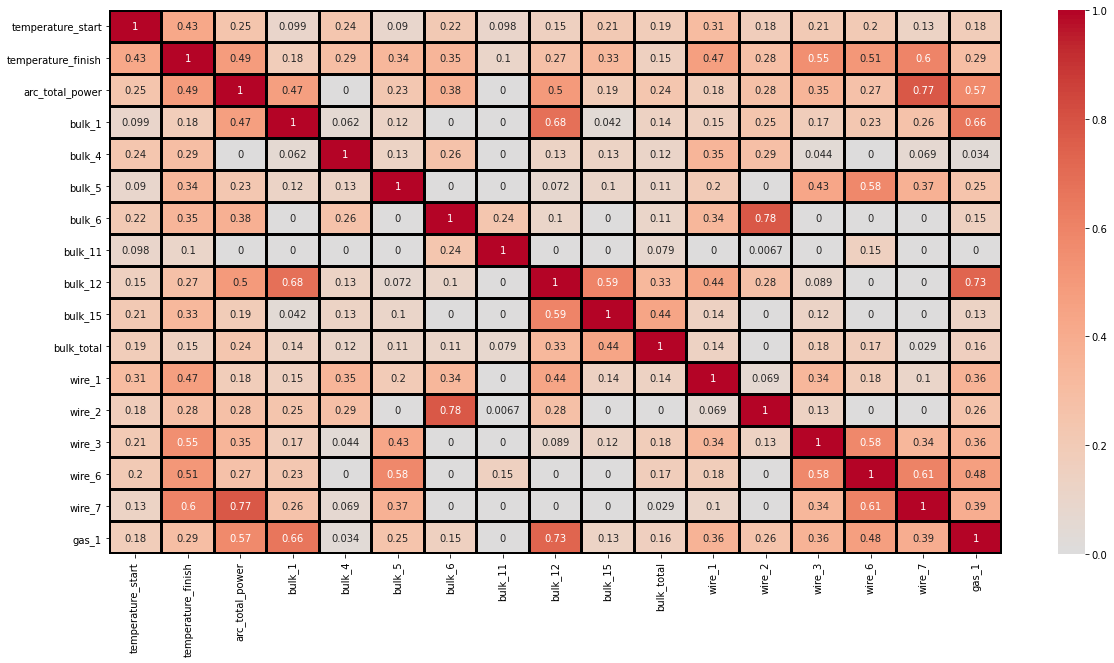

In [41]:
plt.figure(figsize=(20, 10))
sns.heatmap(
    total_df.phik_matrix(interval_cols=total_df.columns),
    cmap='coolwarm',
    center=0,
    annot=True,
    linewidths=2,
    linecolor='black',
)

### Промежуточный вывод

- Избавились от мултиколинеарности;
- Избавились от переменных, которые никак не объясняют целевую;

## Обучение классических моделей

### Подготовка выборок

In [42]:
X = total_df.drop('temperature_finish', axis=1)
y = total_df['temperature_finish']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [44]:
total_df

,temperature_start,temperature_finish,arc_total_power,bulk_1,bulk_4,bulk_5,bulk_6,bulk_11,bulk_12,bulk_15,bulk_total,wire_1,wire_2,wire_3,wire_6,wire_7,gas_1
key,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,3.718736,0.0,43.0,0.0,0.0,0.0,206.0,154.0,554.0,60.059998,0.00000,0.0,0.0,0.0,29.749986
2,1581.0,1602.0,2.588349,0.0,73.0,0.0,0.0,0.0,206.0,154.0,584.0,96.052315,0.00000,0.0,0.0,0.0,12.555561
3,1596.0,1599.0,5.019223,0.0,34.0,0.0,0.0,0.0,205.0,153.0,547.0,91.160157,0.00000,0.0,0.0,0.0,28.554793
4,1601.0,1625.0,3.400038,0.0,81.0,0.0,0.0,0.0,207.0,154.0,599.0,89.063515,0.00000,0.0,0.0,0.0,18.841219
5,1576.0,1602.0,2.816980,0.0,78.0,0.0,0.0,0.0,203.0,152.0,589.0,89.238236,9.11456,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,3.868721,0.0,0.0,0.0,0.0,0.0,256.0,223.0,3214.0,89.150879,0.00000,0.0,0.0,0.0,7.125735
2496,1554.0,1591.0,5.070316,0.0,63.0,0.0,0.0,0.0,256.0,226.0,3292.0,114.179527,0.00000,0.0,0.0,0.0,9.412616
2497,1571.0,1589.0,4.360918,0.0,85.0,0.0,0.0,0.0,230.0,226.0,3162.0,94.086723,9.04800,0.0,0.0,0.0,6.271699


### Создание пайплайна

In [45]:
pipeline = Pipeline(
    # Финальный пайплайн
    [('scaler', StandardScaler()), ('model', LinearRegression())]
)

In [46]:
# Параметры линейной регрессии
linreg_params = {}

linreg_params['scaler'] = [StandardScaler(), MinMaxScaler()]
linreg_params['model'] = [LinearRegression()]

# Параметры случайного леса

forest_params = {}

forest_params['scaler'] = [StandardScaler(), MinMaxScaler(), 'passthrough']
forest_params['model__max_depth'] = list(range(1, 100)) + [None]
forest_params['model__min_samples_split'] = list(range(1, 500)) + [None]
forest_params['model__min_samples_leaf'] = list(range(1, 500)) + [None]
forest_params['model__max_features'] = list(range(1, len(X_train.columns))) + [
    None
]
forest_params['model__n_estimators'] = list(range(1, 10000))
forest_params['model'] = [RandomForestRegressor(random_state=RANDOM_STATE)]


catboost_params = {}

catboost_params['scaler'] = [StandardScaler(), MinMaxScaler()]

catboost_params['model__Iterations'] = range(10, 1000)
catboost_params['model__depth'] = range(1, 1000)
catboost_params['model'] = [
    CatBoostRegressor(random_state=RANDOM_STATE, loss_function='MAE')
]

params = [linreg_params, forest_params, catboost_params]

In [48]:
grid_randomized_reg = RandomizedSearchCV(
    pipeline,
    params,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    n_iter=500,
    random_state=RANDOM_STATE,
)

In [ ]:
grid_randomized_reg.fit(X_train, y_train)

In [ ]:
results_df_reg = pd.DataFrame(grid_randomized_reg.cv_results_)
results_df_reg = results_df_reg.sort_values(by=["rank_test_score"])
results_df_reg = results_df_reg.set_index(
    results_df_reg["params"].apply(
        lambda x: "_".join(str(val) for val in x.values())
    )
).rename_axis("kernel")
results_df_reg['mean_test_score'] *= -1
results_df_reg[
    ["params", "rank_test_score", "mean_test_score", "std_test_score"]
].head(10)

Чемпион среди классической модели. 

In [ ]:
grid_randomized_reg.best_estimator_

In [ ]:
# Сохраним скейлер и модель
scaler = grid_randomized_reg.best_estimator_[0]
classical_model = grid_randomized_reg.best_estimator_[1]

In [ ]:
# Сохраним модель
classical_model = grid_randomized_reg.best_estimator_[1]

In [ ]:
feat_importances = pd.Series(
    classical_model.feature_importances_, index=X.columns
)
feat_importances.sort_values().plot(kind='barh')
plt.title("Топ фичей, объясняющих модель")
plt.show()

In [ ]:
# Проверяем на тестовых данных
y_pred = classical_model.predict(X_test)
mean_absolute_error(y_test, y_pred)

## Общий вывод

Перед нами стояла задача разработать модель, которая могла бы предсказать температуру сплава по операциям, которые производятся со сплавом. 

**Что мы сделали:**

- Загрузили данные, визуально оценили их;
- Избавились от выбросов и неадекватных данных, заполнили пропуски;
- Разработали новые фичи, выделили целевую переменную;
- Собрали данные в единственный датафрейм, провели корреляционный анализ, избавились от мультиколинеарности;
- Собрали пайплайн, подготавливающий данные, протестировали несколько моделей;
- Лучше всего себя показал случайный лес. **MAE на тестовой выборке 6.73**;

**Рекомендации для бизнеса:**

- Обогатить датасет данными о тех сыпучих материалах и проволоках, которых сильно не хватало в текущих наборах данных. Например bulk_8;
- Предоставить дополнительные данные о химическом составе стали, которая подаётся на вход. Вероятно, сплавы с разным составом нагреваются по-разному;
- Повторить цикл обучения и посмотреть на результаты